## First download all of the necessary data

---

Press "Shift + Enter" to run each cell sequentially. Alternatively, you can press "Cmd/Ctrl + F9" to run all cells and then scroll down to bottom cell.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['BASE_PATH']='/tf/notebooks/jwhwang/vqa/mypythia'
BASE_PATH = os.environ['BASE_PATH']

In [2]:
!echo $BASE_PATH

/tf/notebooks/jwhwang/vqa/mypythia


In [17]:
!mkdir -p $BASE_PATH/content/

In [19]:
# Download Pre-requisites needed for running the e2e model
%cd $BASE_PATH/content/

!mkdir model_data
!wget -O $BASE_PATH/content/model_data/vocabulary_captioning_thresh5.txt https://dl.fbaipublicfiles.com/pythia/data/vocabulary_captioning_thresh5.txt
!wget -O $BASE_PATH/content/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
!wget -O $BASE_PATH/content/model_data/butd.pth https://dl.fbaipublicfiles.com/pythia/pretrained_models/coco_captions/butd.pth
!wget -O $BASE_PATH/content/model_data/butd.yaml https://dl.fbaipublicfiles.com/pythia/pretrained_models/coco_captions/butd.yml
!wget -O $BASE_PATH/content/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml
!wget -O $BASE_PATH/content/model_data/detectron_weights.tar.gz https://dl.fbaipublicfiles.com/pythia/data/detectron_weights.tar.gz
!tar xf $BASE_PATH/content/model_data/detectron_weights.tar.gz

[Errno 2] No such file or directory: '$BASE_PATH/content/'
/tf/notebooks/jwhwang/vqa/pythia/content
mkdir: cannot create directory ‘model_data’: File exists
--2020-03-08 02:28:56--  https://dl.fbaipublicfiles.com/pythia/data/vocabulary_captioning_thresh5.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71552 (70K) [text/plain]
Saving to: ‘/tf/notebooks/jwhwang/vqa/pythia//content/model_data/vocabulary_captioning_thresh5.txt’

/tf/notebooks/jwhwa 100%[===================>]  69.88K   180KB/s    in 0.4s    

2020-03-08 02:28:58 (180 KB/s) - ‘/tf/notebooks/jwhwang/vqa/pythia//content/model_data/vocabulary_captioning_thresh5.txt’ saved [71552/71552]

--2020-03-08 02:28:58--  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth
Resolving dl.fbaipublic

## Now, install some particular dependencies

In [20]:
# Install dependencies
!pip install ninja yacs cython matplotlib demjson
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-gl5h894g
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-gl5h894g
  Stored in directory: /tmp/pip-ephem-wheel-cache-p40z4_8k/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


## Install fastText for installing Pythia

In [38]:
%cd {BASE_PATH}/content/

/tf/notebooks/jwhwang/vqa/pythia/content


In [39]:
%cd {BASE_PATH}/content/
%rm -rf fastText
!git clone https://github.com/facebookresearch/fastText.git fastText
%cd {BASE_PATH}/content/fastText
!pip install -e .

/tf/notebooks/jwhwang/vqa/pythia/content
Cloning into 'fastText'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 3679 (delta 2), reused 17 (delta 1), pack-reused 3657
Receiving objects: 100% (3679/3679), 8.10 MiB | 4.20 MiB/s, done.
Resolving deltas: 100% (2313/2313), done.
Checking connectivity... done.
/tf/notebooks/jwhwang/vqa/pythia/content/fastText
Obtaining file:///tf/notebooks/jwhwang/vqa/pythia/content/fastText
ERROR: pythia 0.3 has requirement requests==2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: pythia 0.3 has requirement tensorboardX==1.2, but you'll have tensorboardx 2.0 which is incompatible.
ERROR: pythia 0.3 has requirement torch==1.0.1.post2, but you'll have torch 1.4.0 which is incompatible.
ERROR: pythia 0.3 has requirement torchvision==0.2.2, but you'll have torchvision 0.5.0 which is incompatible.
ERROR: pythia 0.3 has requirement tqdm==4.

## Install Pythia now

In [3]:
%cd {BASE_PATH}/content/
%rm -rf pythia
!git clone https://github.com/facebookresearch/pythia.git pythia
%cd {BASE_PATH}/content/pythia
# Don't modify torch version
!sed -i '/torch/d' requirements.txt
!pip install -e .
import sys
sys.path.append(os.path.join(BASE_PATH,'/content/pythia'))

## Install maskrcnn-benchmark now

In [4]:
# Install maskrcnn-benchmark to extract detectron features
%cd {BASE_PATH}/content
!git clone https://gitlab.com/meetshah1995/vqa-maskrcnn-benchmark.git
%cd {BASE_PATH}/content/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!python setup.py build
!python setup.py develop
sys.path.append(os.path.join(BASE_PATH, '/content/vqa-maskrcnn-benchmark'))

## Demo

The class handles everything from feature extraction, token extraction and predicting the answer

In [3]:
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd


import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO

from maskrcnn_benchmark import _C
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


from pythia.utils.configuration import ConfigNode
from pythia.tasks.processors import VocabProcessor, CaptionProcessor
from pythia.models.butd import BUTD
from pythia.common.registry import registry
from pythia.common.sample import Sample, SampleList

class PythiaDemo:
  TARGET_IMAGE_SIZE = [448, 448]
  CHANNEL_MEAN = [0.485, 0.456, 0.406]
  CHANNEL_STD = [0.229, 0.224, 0.225]
  
  def __init__(self):
    self._init_processors()
    self.pythia_model = self._build_pythia_model()
    self.detection_model = self._build_detection_model()
    
  def _init_processors(self):
    with open(os.path.join(BASE_PATH,"content/model_data/butd.yaml")) as f:
      config = yaml.load(f)
    
    config = ConfigNode(config)
    # Remove warning
    config.training_parameters.evalai_inference = True
    registry.register("config", config)
    
    self.config = config
    
    captioning_config = config.task_attributes.captioning.dataset_attributes.coco
    text_processor_config = captioning_config.processors.text_processor
    caption_processor_config = captioning_config.processors.caption_processor
    
    text_processor_config.params.vocab.vocab_file = os.path.join(BASE_PATH,"content/model_data/vocabulary_captioning_thresh5.txt")
    caption_processor_config.params.vocab.vocab_file = os.path.join(BASE_PATH,"content/model_data/vocabulary_captioning_thresh5.txt")
    self.text_processor = VocabProcessor(text_processor_config.params)
    self.caption_processor = CaptionProcessor(caption_processor_config.params)

    registry.register("coco_text_processor", self.text_processor)
    registry.register("coco_caption_processor", self.caption_processor)
    
  def _build_pythia_model(self):
    #     state_dict = torch.load(os.path.join(BASE_PATH,'content/model_data/butd.pth'))
    state_dict = torch.load(os.path.join(BASE_PATH,'save/captioning_coco_butd/butd_final.pth'))
    model_config = self.config.model_attributes.butd
    model_config.model_data_dir = os.path.join(BASE_PATH,"content/")
    model = BUTD(model_config)
    model.build()
    model.init_losses_and_metrics()
    
    if list(state_dict.keys())[0].startswith('module') and \
       not hasattr(model, 'module'):
      state_dict = self._multi_gpu_state_to_single(state_dict)
          
    model.load_state_dict(state_dict)
    model.to("cuda")
    model.eval()
    
    return model
  
  def _multi_gpu_state_to_single(self, state_dict):
    new_sd = {}
    for k, v in state_dict.items():
        if not k.startswith('module.'):
            raise TypeError("Not a multiple GPU state of dict")
        k1 = k[7:]
        new_sd[k1] = v
    return new_sd
  
  def predict(self, url):
    with torch.no_grad():
      detectron_features = self.get_detectron_features(url)

      sample = Sample()
      sample.dataset_name = "coco"
      sample.dataset_type = "test"
      sample.image_feature_0 = detectron_features
      sample.answers = torch.zeros((5, 10), dtype=torch.long)

      sample_list = SampleList([sample])
      sample_list = sample_list.to("cuda")

      tokens = self.pythia_model(sample_list)["captions"]
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return tokens

  def mypredict(self, npy):
    with torch.no_grad():
      detectron_features = torch.tensor(npy, dtype=torch.float32)

      sample = Sample()
      sample.dataset_name = "coco"
      sample.dataset_type = "test"
      sample.image_feature_0 = detectron_features
      sample.answers = torch.zeros((5, 10), dtype=torch.long)

      sample_list = SampleList([sample])
      sample_list = sample_list.to("cuda")
      print(f"sample_list: {sample_list!r}")
      tokens = self.pythia_model(sample_list) #["captions"]
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return tokens
    
  
  def _build_detection_model(self):

      cfg.merge_from_file(os.path.join(BASE_PATH,'content/model_data/detectron_model.yaml'))
      cfg.freeze()

      model = build_detection_model(cfg)
      checkpoint = torch.load(os.path.join(BASE_PATH,'content/model_data/detectron_model.pth'), 
                              map_location=torch.device("cpu"))

      load_state_dict(model, checkpoint.pop("model"))

      model.to("cuda")
      model.eval()
      return model
  
  def get_actual_image(self, image_path):
      if image_path.startswith('http'):
          path = requests.get(image_path, stream=True).raw
      else:
          path = image_path
      
      return path

  def _image_transform(self, image_path):
      path = self.get_actual_image(image_path)

      img = Image.open(path)
      im = np.array(img).astype(np.float32)
      im = im[:, :, ::-1]
      im -= np.array([102.9801, 115.9465, 122.7717])
      im_shape = im.shape
      im_size_min = np.min(im_shape[0:2])
      im_size_max = np.max(im_shape[0:2])
      im_scale = float(800) / float(im_size_min)
      # Prevent the biggest axis from being more than max_size
      if np.round(im_scale * im_size_max) > 1333:
           im_scale = float(1333) / float(im_size_max)
      im = cv2.resize(
           im,
           None,
           None,
           fx=im_scale,
           fy=im_scale,
           interpolation=cv2.INTER_LINEAR
       )
      img = torch.from_numpy(im).permute(2, 0, 1)
      return img, im_scale


  def _process_feature_extraction(self, output,
                                 im_scales,
                                 feat_name='fc6',
                                 conf_thresh=0.2):
      batch_size = len(output[0]["proposals"])
      n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
      score_list = output[0]["scores"].split(n_boxes_per_image)
      score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
      feats = output[0][feat_name].split(n_boxes_per_image)
      cur_device = score_list[0].device

      feat_list = []

      for i in range(batch_size):
          dets = output[0]["proposals"][i].bbox / im_scales[i]
          scores = score_list[i]

          max_conf = torch.zeros((scores.shape[0])).to(cur_device)

          for cls_ind in range(1, scores.shape[1]):
              cls_scores = scores[:, cls_ind]
              keep = nms(dets, cls_scores, 0.5)
              max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                           cls_scores[keep],
                                           max_conf[keep])

          keep_boxes = torch.argsort(max_conf, descending=True)[:100]
          feat_list.append(feats[i][keep_boxes])
      return feat_list

  def masked_unk_softmax(self, x, dim, mask_idx):
      x1 = F.softmax(x, dim=dim)
      x1[:, mask_idx] = 0
      x1_sum = torch.sum(x1, dim=1, keepdim=True)
      y = x1 / x1_sum
      return y
    
  def get_detectron_features(self, image_path):
      im, im_scale = self._image_transform(image_path)
      img_tensor, im_scales = [im], [im_scale]
      current_img_list = to_image_list(img_tensor, size_divisible=32)
      current_img_list = current_img_list.to('cuda')
      with torch.no_grad():
          output = self.detection_model(current_img_list)
      feat_list = self._process_feature_extraction(output, im_scales, 
                                                  'fc6', 0.2)
      return feat_list[0]

### If the command below fails with 'CUDNN_EXECUTION_FAILED', try rerunning the cell

In [4]:
demo = PythiaDemo()

/tf/notebooks/miniconda3/envs/vqa/lib/python3.6/site-packages/ipykernel_launcher.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


## Use the text fields below to ask a question on an image

Image URL can be any http/https URL. We show top 5 predictions from Pythia. Confidence shows how confident Pythia model was about a particular prediction.

In [5]:
# bring vizwiz data
# !ls data/vizwiz/train/train.json
import json
import matplotlib.pyplot as plt

In [19]:
with open("./data/vizwiz/annotations/train.json", 'r') as f:
    train_json = json.load(f)

In [6]:
with open("./data/vizwiz/annotations/test.json", 'r') as f:
    test_json = json.load(f)

In [7]:
test_anno = np.load("./data/imdb/coco_captions/imdb_vizwiz_val_cut_coco.npy", allow_pickle=True)

In [16]:
anno_df = pd.DataFrame.from_records(test_anno[1:])

In [40]:
anno_df.head(1)

,image_name,image_id,feature_path,caption_id,caption_str,caption_tokens,reference_tokens
0,VizWiz_val_00000000,23431,VizWiz_val_00000000.npy,117155,A computer screen shows a repair prompt on the...,"[<s>, A, computer, screen, shows, a, repair, p...","[[<s>, A, computer, screen, shows, a, repair, ..."


In [27]:
# img_anno = []
# for img_str in train_json["images"]:
#     img_anno.append({"image_id":img_str["id"], "image_name":img_str["file_name"].split(".")[0], "file_name":img_str["file_name"]})
    
# # get annos for train
# anno_anno = []
# for ann in train_json["annotations"]:
#     anno_anno.append({"image_id":ann["image_id"], "caption_id":ann["id"], "caption_str":ann["caption"]})
        
# # for train
# img_anno_df = pd.DataFrame(img_anno)
# anno_anno_df = pd.DataFrame(anno_anno)
# anno_df = pd.merge(anno_anno_df, img_anno_df)
# # anno_df = anno_df.drop("image_idi_", axis=1)

# anno_df.head(1) 

,image_id,caption_id,caption_str,image_name,file_name
0,0,0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,VizWiz_train_00000000,VizWiz_train_00000000.jpg


In [36]:

# os.path.join(BASE_PATH, "data/vizwiz/train/", anno_df[anno_df["image_name"]=="VizWiz_train_00000000"]["file_name"][0])

'VizWiz_train_00000000.jpg'

In [55]:
def inference_test(image_name):
    fig = plt.figure(figsize=(10,10))
    image_text = anno_df[anno_df["image_name"]==image_name]["caption_str"]
    
    img = plt.imread(os.path.join(BASE_PATH, "data/vizwiz/val/", image_name+'.jpg'))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    fr_npy = np.load(os.path.join(BASE_PATH, "data/vizwiz/val_npy/", image_name+'.npy'))
    fig.add_subplot(1, 2, 2)
    plt.imshow(fr_npy)
    
    tokens = demo.mypredict(fr_npy)
    predict = demo.caption_processor(tokens["captions"].tolist()[0])["caption"]
    print(f"answer: {image_text!r}")
    print(f"tokens: {tokens!r}")
    print(f"predict: {predict!r}")
    
def init_widgets(url):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )

  image_text.value = url
  submit_button = widgets.Button(description="Caption the image!")

  display(image_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text
  ))
  
  return image_text
  
def on_button_click(b, image_text):
  clear_output()
  image_path = demo.get_actual_image(image_text.value)
  image = Image.open(image_path)
  
  tokens = demo.predict(image_text.value)
  answer = demo.caption_processor(tokens.tolist()[0])["caption"]
  init_widgets(image_text.value)
  display(image)
  
  display(HTML(answer))
 

image_text = init_widgets(
    "http://images.cocodataset.org/train2017/000000505539.jpg"
)


Text(value='http://images.cocodataset.org/train2017/000000505539.jpg', description='Image URL')

Button(description='Caption the image!', style=ButtonStyle())

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 0.0000, 0.0000,  ..., 3.2288, 0.0000, 0.9754],
         [0.0000, 4.6796, 0.0000,  ..., 4.4729, 0.0000, 0.2032],
         [1.3178, 1.7967, 0.0000,  ..., 0.1191, 0.0000, 0.0000],
         ...,
         [0.2011, 1.3940, 0.0000,  ..., 1.8149, 0.0000, 2.3793],
         [0.6580, 1.9187, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.5501, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 0    A computer screen shows a repair prompt on the...
1    a computer screen with a repair automatically ...
2    partial computer screen showing the need of re...
3    Part of a computer monitor showing a computer ...


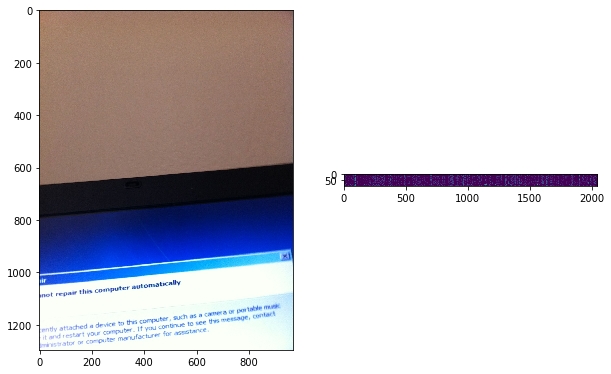

In [56]:
inference_test("VizWiz_val_00000000")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 0.4858, 0.8406,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.5270,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 3.3138, 0.3669, 0.0000],
         ...,
         [1.6385, 3.4127, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.1029, 0.0000,  ..., 0.0000, 0.0000, 0.6155],
         [1.7582, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 5    A person is holding a bottle that has medicine...
6        A bottle of medication has a white twist top.
7    night time medication bottle being held by som...
8    a person holding a small black bottle of NIGHT...


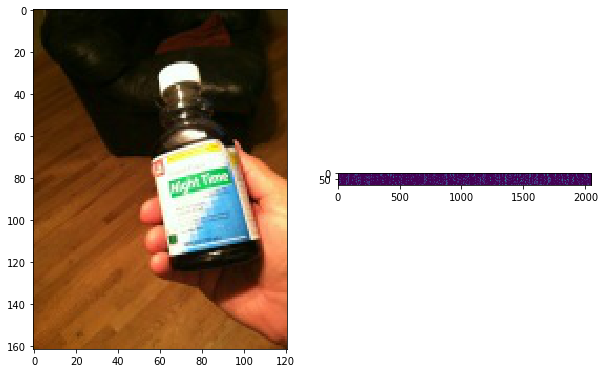

In [57]:
inference_test("VizWiz_val_00000001")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[1.5767, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0089, 1.1495, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9947, 3.1325, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.9164, 0.8436,  ..., 0.7304, 0.0000, 1.9925],
         [0.0000, 2.9564, 0.0000,  ..., 0.0000, 1.6384, 0.0000],
         [1.0896, 3.4047, 0.0000,  ..., 4.9664, 0.0000, 1.0890]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 10    a white paper showing an image of black and br...
11    A library book with pictures of two dogs on th...
12    A book with a black and a tan dog walking down...
13            The book cover shows two dogs in the s

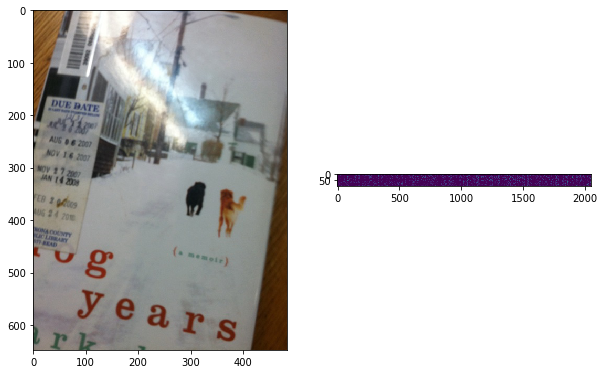

In [58]:
inference_test("VizWiz_val_00000002")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.4575, 2.1163, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.6563, 0.0000,  ..., 3.8712, 0.0000, 0.0000],
         [0.0586, 0.0000, 0.0000,  ..., 2.7094, 0.0000, 0.0000],
         ...,
         [0.0000, 2.6412, 0.0000,  ..., 0.0000, 0.0000, 0.5991],
         [0.1182, 2.9955, 0.0000,  ..., 0.9710, 0.0000, 0.5208],
         [0.0000, 4.2366, 0.0000,  ..., 5.6133, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 15    A white box is to the left of a blue box on a ...
16    A small rectangular red and white box next to ...
17    two boxes of  medicine, one white and red and ...
18    Two boxes that appear to contain medication or

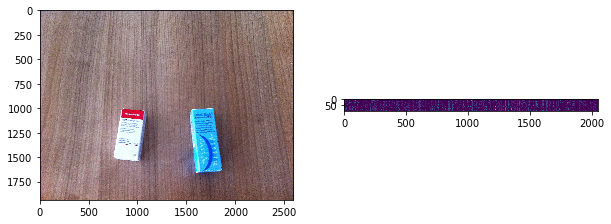

In [59]:
inference_test("VizWiz_val_00000003")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[1.1133, 3.6923, 1.1844,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.3217, 0.4312,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.8939, 0.0000,  ..., 2.2032, 0.0000, 0.0000],
         ...,
         [2.6550, 1.6294, 0.7276,  ..., 3.4219, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.7488,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 4.0679, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 20    close up of a computer monitor that is powered...
21             A monitor has a message displayed on it.
22    Pictured here is a screenshot that shows an er...
23    Computer screen displaying an error saying the

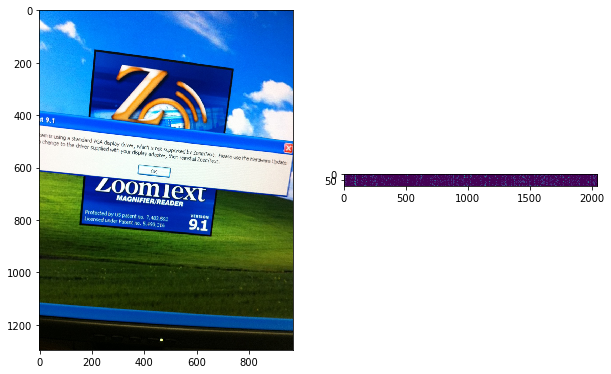

In [60]:
inference_test("VizWiz_val_00000004")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.7619, 0.0000, 0.0000,  ..., 1.5241, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.1902, 0.6801, 0.2460,  ..., 0.7993, 0.0000, 0.0000],
         ...,
         [0.0000, 2.7878, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.2429, 0.0000, 1.8418,  ..., 0.9079, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.3980,  ..., 2.7104, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 25    a DELL laptop computer screen  showing window ...
26    A computer screen with a windows dialogue box ...
27    Computer screen showing a Windows 7 home premi...
28            A dell laptop with windows 7 home scre

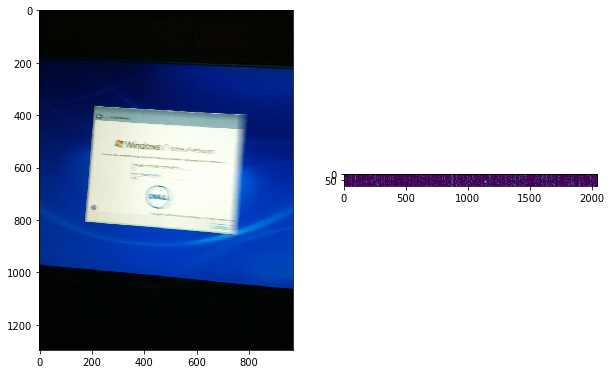

In [61]:
inference_test("VizWiz_val_00000005")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 4.1559, 0.0000,  ..., 2.0532, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 2.4288, 0.8354,  ..., 2.1870, 0.0000, 0.0000],
         ...,
         [0.1943, 0.0000, 0.5217,  ..., 1.2272, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 3.2074, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 30    Quality issues are too severe to recognize vis...
31    Quality issues are too severe to recognize vis...
32    Quality issues are too severe to recognize vis...
33    Quality issues are too severe to recognize vis

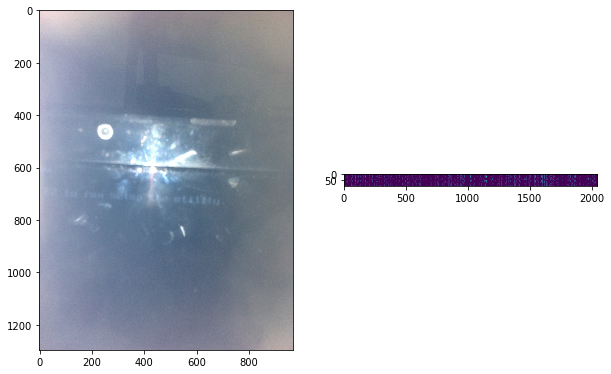

In [62]:
inference_test("VizWiz_val_00000006")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 4.0442, 0.0000,  ..., 3.2573, 0.0000, 0.6569],
         [0.5837, 6.2215, 0.0000,  ..., 4.1725, 0.0000, 0.0000],
         [0.0000, 0.1974, 0.0000,  ..., 1.0127, 0.0000, 0.9503],
         ...,
         [0.0000, 0.4407, 0.0000,  ..., 0.0000, 0.0000, 0.1833],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.5513, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 40    Quality issues are too severe to recognize vis...
41    A bottle of lotion on the table in front of so...
42    Quality issues are too severe to recognize vis...
43    A small bottle of lotion on a table above a pe

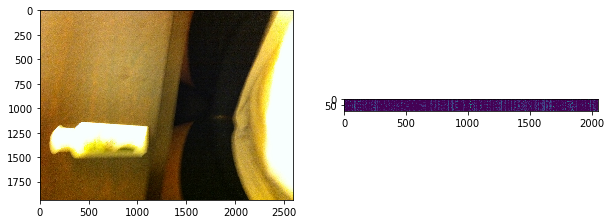

In [63]:
inference_test("VizWiz_val_00000008")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 1.5253, 0.0000,  ..., 1.2470, 0.0000, 0.0000],
         [1.3631, 3.1251, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.9920, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 3.7755, 0.0000,  ..., 2.3429, 0.0000, 0.0000],
         [1.7865, 0.0000, 0.0000,  ..., 1.2216, 0.0000, 0.0000],
         [0.1186, 2.4148, 0.0000,  ..., 1.3194, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 45    The interior of a bus has a horizontal bar nea...
46    A curving metal handrail with a horizontal cro...
47    The overhead handrails on a bus in the city ar...
48               A vehicle has a window and a gray b

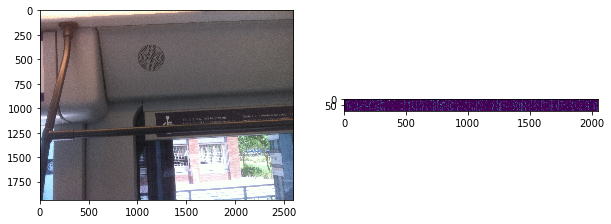

In [64]:
inference_test("VizWiz_val_00000009")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[3.7361, 2.2614, 1.1004,  ..., 3.1131, 0.0000, 0.0000],
         [2.4247, 0.0000, 1.0516,  ..., 0.0000, 3.7357, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6880, 1.6121],
         ...,
         [2.3321, 4.7852, 4.8314,  ..., 4.4716, 0.0000, 0.0000],
         [0.0000, 0.0000, 2.1803,  ..., 0.0000, 0.0000, 0.7679],
         [1.5110, 0.0000, 0.1587,  ..., 0.0000, 0.0000, 0.3581]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 50    A view of a building with a picture of a man o...
51    SKY VIEW SNAPSHOT OF TREES IN FRONT OF A GIANT...
52    view of trees and a nearby sign promoting Isti...
53    downtown photo of several buildings, trees peo

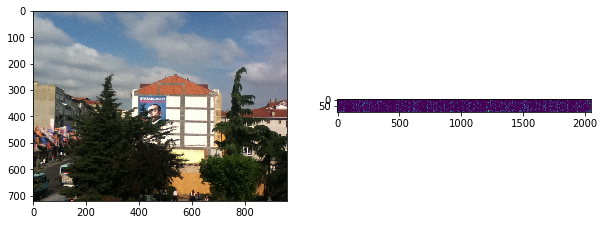

In [65]:
inference_test("VizWiz_val_00000010")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 1.7338, 0.0000,  ..., 0.0000, 0.8175, 0.0000],
         [0.5854, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0781, 0.1244, 0.0000,  ..., 0.0000, 0.0285, 0.0000],
         ...,
         [0.0000, 0.0000, 0.8997,  ..., 1.1936, 0.2391, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.3356, 0.0000, 0.0000],
         [0.3457, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 55    Quality issues are too severe to recognize vis...
56    A white object with elastic sides sitting on a...
57    A baby diaper keep in the table shown by the i...
58       A opened up Diaper laying on a wooden surfa

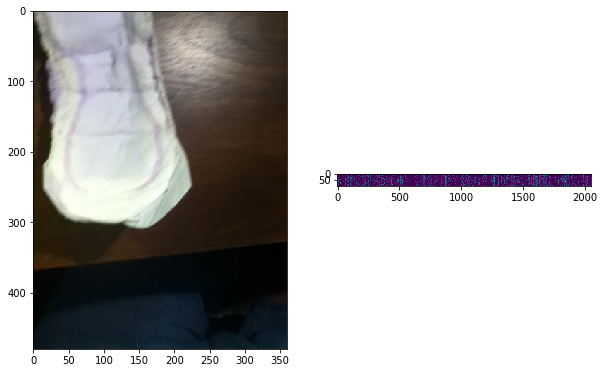

In [66]:
inference_test("VizWiz_val_00000011")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[2.0018, 0.0000, 2.7302,  ..., 0.0000, 0.2643, 0.0000],
         [0.0000, 6.3815, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.7535, 0.0000, 1.6016,  ..., 0.0000, 0.9187, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.4651, 0.0000,  ..., 5.4064, 0.0000, 0.0000],
         [0.0000, 0.4119, 0.0000,  ..., 2.7403, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 60              appears to be a picture of prepaid card
61    Large orange and white label with a person's h...
62    Someone is holding a white envelope with an or...
63    The package contains information about the enc

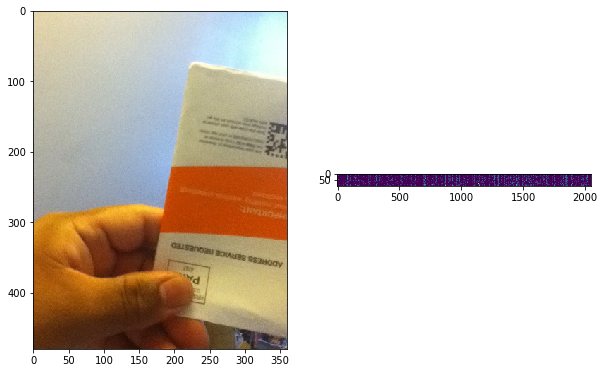

In [67]:
inference_test("VizWiz_val_00000012")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 0.0000, 0.0000,  ..., 6.6396, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 3.1658, 0.0000, 0.0000],
         [0.0000, 1.6669, 0.0000,  ..., 2.1471, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 3.1595, 0.0000, 0.0000],
         [0.0000, 2.1553, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.7047, 0.0000, 0.0000,  ..., 0.8730, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 65    A white piece of paper with a blue emblem off ...
66    Quality issues are too severe to recognize vis...
67    Quality issues are too severe to recognize vis...
68    Quality issues are too severe to recognize vis

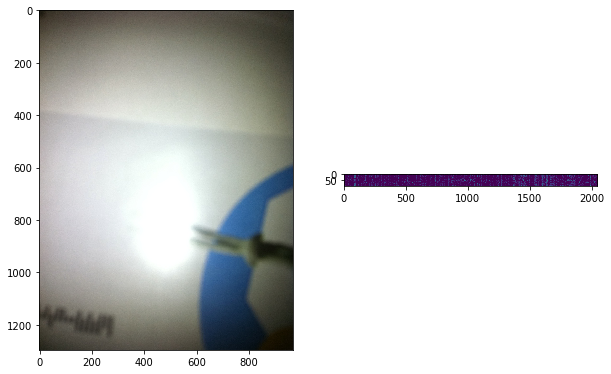

In [68]:
inference_test("VizWiz_val_00000013")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 4.8300, 0.0000,  ..., 1.2495, 0.0000, 0.0000],
         [0.0000, 4.4222, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.2200, 1.7200, 0.4446,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.5732, 0.0000, 1.4740,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 2.4490, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 75    Quality issues are too severe to recognize vis...
76    A set of hand held electronic children's learn...
77    Two packages with children's calculators in th...
78    two kids learning toys still in package laying

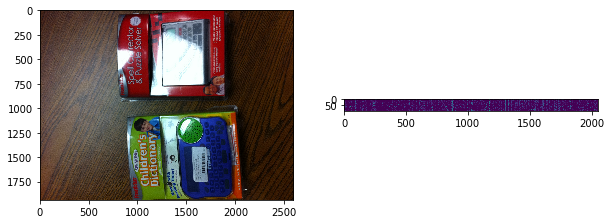

In [69]:
inference_test("VizWiz_val_00000015")

sample_list: SampleList([('dataset_name', ['coco']), ('dataset_type', ['test']), ('image_feature_0', tensor([[[0.0000, 1.7106, 0.0000,  ..., 3.7687, 0.0000, 0.0000],
         [0.0000, 0.3151, 2.2534,  ..., 3.2426, 0.0000, 0.0000],
         [0.0000, 2.7415, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.4293,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.5871, 0.0000,  ..., 1.9426, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.7392,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')), ('answers', tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], device='cuda:0'))])
answer: 80    A picture of what appears to be some kind of f...
81    Obstructed view of some type of microwavable o...
82    Package of frozen food on top of a white surface.
83    Quality issues are too severe to recognize vis

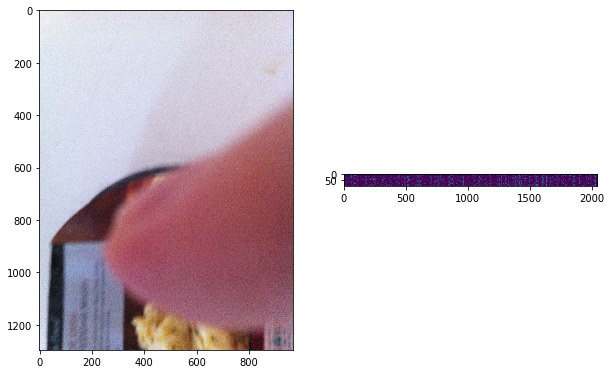

In [70]:
inference_test("VizWiz_val_00000016")